# Short Introduction to Pytorch

Author : Alasdair Newson

Adapted by Loic Le Folgoc. If you have questions, contact me at loic.lefolgoc@telecom-paris.fr

The second part of this TP is a very short introduction to Pytorch (https://pytorch.org/), an auto-differentiation library which we will be using in the next part to implement an MLP model.

The following commands will make sure that you have all the necessary packages

In [1]:
import os
import pdb

import matplotlib.pyplot as plt
import numpy as np
import torch

%matplotlib inline

## What is Pytorch?

Pytorch is a library written by Meta which allows easy implementation of deep neural networks. In particular, it provides automatic differentiation so that the user does not have to determine gradients manually, which can be extremely long even for simple networks, as you have seen in the previous part of the lab.

This, in turn allows a user to apply techniques such as stochastic gradient descent for training purposes. The differentiation graph is created symbolically when the network is created. Since a neural network is simply a cascade (or concatenation) of simple functions, the network in Pytorch is simply a sequence of functions which are applied to one or several variables. The output of the final function is the output of the network.

For instance, if the input were ```x``` and the network consisted of two functions ```a``` and ```b```, you could create the network simply by writing :

```y = b(a(x))```

However, it is clear that these functions and variables must be of some special type, so that the computer can figure out how to carry out the automatic differentiation for training. Pytorch provides these functions and variables in the form of the following object :

- **Tensors:** any array corresponding to weights, constants. Most elementary operations in `torch` between tensors create new tensors.
- **Parameters:** A type of tensor specially made to hold trainable parameters. If you define your own Network as a class, its trainable parameters will be the ones registered as ```Parameters```.

These objects must be created with the Pytorch package. The functions which create the structure of the network, such as matrix multiplication, addition, and non-linearities must be carried out using special Pytorch functions. For example :

- ```torch.matmul``` (matrix multiplication)
- ```torch.nn.sigmoid``` (sigmoid non-linearity)
- ```torch.add``` (addition)

Note that some of the more basic functions are overloaded from standard python syntax, addition for example, so it is not always necessary to use `torch.add`. When in doubt, it is best to explicitly use a Pytorch function.



We will provide more information about Pytorch in the context of building and training neural networks in the next part of the lab. For further documentation, see :

- https://pytorch.org/

## Using Pytorch - some examples

We are now going to take a brief tour of the Pytorch syntax, and implement some of the ideas illustrated above. First, let's create some constants.

In [2]:
a = torch.tensor(3)
b = torch.tensor(2)
c = a + b

In [3]:
print(type(a))
print(a)

<class 'torch.Tensor'>
tensor(3)


In [4]:
print(type(c))
print(c)

<class 'torch.Tensor'>
tensor(5)


As you can see, you can carry out basic operations on tensors as if they were integers.

###Converting numpy arrays into tensors

An interesting feature of Pytorch is the ability to turn numpy arrays into tensors and vice-versa. However, you can't make operations between them.

In [5]:
a = np.array([1, 2, 3, 4])
b = torch.tensor(a)  # Change np.array into torch.tensor
c = b.numpy()  # Change torch.tensor into np.array

print(type(a))
print(a)

print(type(b))
print(b)

print(type(c))
print(c)

<class 'numpy.ndarray'>
[1 2 3 4]
<class 'torch.Tensor'>
tensor([1, 2, 3, 4], dtype=torch.int32)
<class 'numpy.ndarray'>
[1 2 3 4]


In [6]:
try:
    m = torch.multiply(a, b)
    print("It seems that you can multiply numpy arrays with torch tensors.")
except:
    print("See? You can't multiply a numpy array with a tensor")

See? You can't multiply a numpy array with a tensor


### Storing your tensor on a given device

Since torch tensors behave the same as numpy arrays, you could wonder why not only using numpy arrays?

One of the main benefit of torch tensors is the ability to store them on the devide of your choice. It means that they can be stored on your CPU (as numpy does) or on your GPU thanks to the command ```.to()```

For that, let's first take an other example:

In [7]:
a = np.array([1, 0, 2])
b = torch.tensor(a)

Here, the tensor is stored on the CPU by default. We can check it with the following command

In [8]:
print(b.device)
print(b)

cpu
tensor([1, 0, 2], dtype=torch.int32)


Let's change it to GPU

**N.B.** If you're using google colab, you must check that your execution environment is using a GPU or TPU. For that, go to ```Execution``` &rarr; ```Modify Execution Type``` and check your material is ```GPU``` or ```TPU```. If not, change it and reload the environment.

In [9]:
if torch.cuda.is_available():  # We first check if a GPU is available:
    c = b.to("cuda")
    print("We changed the device")

print(c.device)
print(c)

We changed the device
cuda:0
tensor([1, 0, 2], device='cuda:0', dtype=torch.int32)


In [10]:
print(f"Cuda is available: {torch.cuda.is_available()}")
print(f"Number of cuda devices: {torch.cuda.device_count()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Cuda device: {torch.cuda.device(torch.cuda.current_device())}")
print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Cuda is available: True
Number of cuda devices: 1
Current device: 0
Cuda device: <torch.cuda.device object at 0x000001F9D6637BC0>
Device name: Quadro T2000


Note that we can also change a tensor's device by using ```.cuda()``` and ```.cpu()``` functions.

Since we're able to change the device of a tensor, let's see why this is a benefit (run the cell at least twice if necessary to get relevant numbers):

In [11]:
import time

b = torch.randn(4096, 4096)
c = b.cuda()


def power(x):
    return x**2


start_time = time.time()
b_ = power(b)
end_time = time.time()
print("Time elapsed:", end_time - start_time, "seconds")

start_time = time.time()
c = power(c)
end_time = time.time()
print("Time elapsed:", end_time - start_time, "seconds")

Time elapsed: 0.02499842643737793 seconds
Time elapsed: 0.038588762283325195 seconds


## Automatic gradient calculation

We now will look at how to carry out automatic differentiation in Pytorch. As an example, we shall take the gradient of (1-img)^2 with respect to img, and see what the result looks like.

**Important:** When you want to compute the gradient of a given tensor, you have to set ```requires_grad``` to ```True```. It indicates that the tensor is added to the computational graph.

torch.Size([768, 1024, 3])


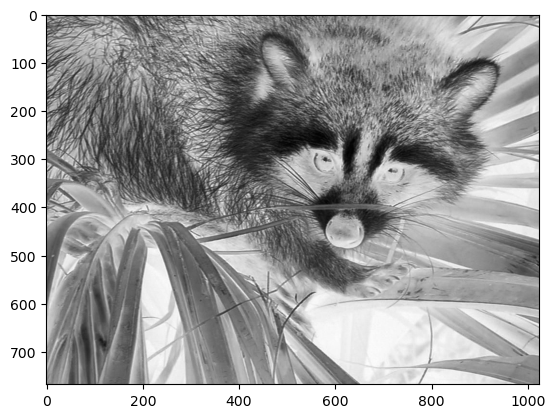

In [12]:
from scipy.datasets import face

img_demo = face().astype(np.float32) / 255.0
torch_img_demo = torch.tensor(img_demo, requires_grad=True)
print(torch_img_demo.shape)


def cost_function(img):
    return torch.sum((1 - img) ** 2)


value = cost_function(torch_img_demo)
value.backward()  # We compute the gradient of 'value' with respect to 'torch_img_demo'
plt.imshow(np.sqrt(torch.sum(torch_img_demo.grad**2, axis=2)), cmap="gray")
plt.show()

## Question:

   - Carry out the analytic differentiation of the function $(1 - \text{img})^2$ with respect to $\text{img}$, to confirm that the result is the same:

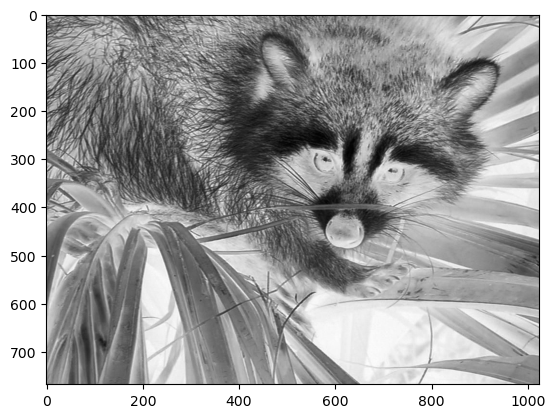

In [13]:
# TO CODE BY STUDENTS

torch_img_demo_grad = -2 * (1 - torch.tensor(img_demo))
plt.imshow(np.sqrt(torch.sum(torch_img_demo_grad**2, axis=2)), cmap="gray")
plt.show()

# END STUDENT CODE

#### Documentation:

  - https://pytorch.org/
  - http://www.deeplearningbook.org/